In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 26 22:03:18 2021

@author: pmarc
Résolution Problème L14 - #1 par Pierre-Marc Juneau, 28 avril 2021
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics as mt
import statsmodels.api as sm
import scipy.stats as sts
import math


In [2]:

donnee = pd.read_csv('../Fichiers/DonneesBiometriquesv0r2.csv')
stats=donnee.describe()
dimensions=donnee.shape
nomsvariables = pd.DataFrame(donnee.columns)

donnee=donnee.dropna()

X=donnee.drop('Poids (kg)', 1)
X=pd.get_dummies(X)
#Normalement il faut enlever une des variables créées par pd.get_dummies
#X=X.drop('Genre_Homme', 1)
Y=donnee["Poids (kg)"]


/tmp/ipykernel_177950/2459345321.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=donnee.drop('Poids (kg)', 1)


In [3]:

"Régression linéaire et multicolinéarité"

modele=sm.OLS(Y,X.assign(const=1))
resultats=modele.fit()
Y_chap = resultats.predict(X.assign(const=1))
resultats.summary()

from statsmodels.stats.outliers_influence import variance_inflation_factor
VIF = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
VIFPanda=pd.DataFrame(VIF)
VIFPanda.index=X.columns
VIFPanda.columns=["VIF"]


In [4]:

"Régression PLS"

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score

pls_model = PLSRegression(n_components=1).fit(X,Y)
Y_chap=pls_model.predict(X)
Y_chap=pd.DataFrame(Y_chap)
R2=r2_score(Y,Y_chap)



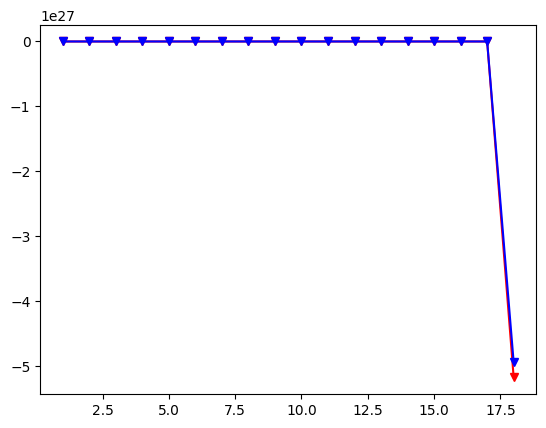

In [10]:

"Déterminer le nombre de composantes principales"


from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.5,random_state=50)


R2_global =list()
Q2_global =list()
for i in np.arange(1,X.shape[1]+1):
    pls_model = PLSRegression(n_components=i).fit(X_train,Y_train)
    Y_chap_train=pls_model.predict(X_train)
    Y_chap_train=pd.DataFrame(Y_chap_train)
    R2=r2_score(Y_train,Y_chap_train)
    R2_global.append(R2)
    Y_chap_test=pls_model.predict(X_test)
    Y_chap_test=pd.DataFrame(Y_chap_test)
    Q2=r2_score(Y_test,Y_chap_test)
    Q2_global.append(Q2)
    
    
ax=plt.plot(np.arange(1,X.shape[1]+1),np.array(R2_global),"-v",c="r");
ax=plt.plot(np.arange(1,X.shape[1]+1),np.array(Q2_global),"-v",c="b");



In [6]:

"Choix"

pls_model = PLSRegression(n_components=2).fit(X,Y)
Y_chap=pls_model.predict(X)
Y_chap=pd.DataFrame(Y_chap)
R2=r2_score(Y,Y_chap)


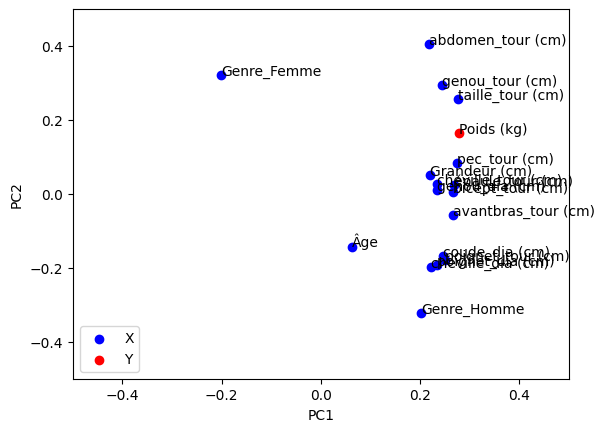

In [7]:

"Loadings plot"

W=pls_model.x_weights_
P=pls_model.x_loadings_
W_s=np.dot(W,np.linalg.inv(np.dot(P.T,W)))
X_loadings=pd.DataFrame(W_s)
X_loadings=pd.concat([X_loadings,pd.DataFrame(X.columns)],axis=1)
X_loadings.index=X.columns
X_loadings.columns=['PC1','PC2','Tag']

Y_loadings=pd.DataFrame(pls_model.y_weights_)
Y_loadings=pd.concat([Y_loadings,pd.DataFrame(["Poids (kg)"])],axis=1)
Y_loadings.index=["Poids (kg)"]
Y_loadings.columns=['PC1','PC2','Tag']


PLS_Loadings=pd.concat([X_loadings,Y_loadings],axis=0)

fig, ax = plt.subplots()
ax.scatter(X_loadings['PC1'], X_loadings['PC2'],color='blue',label='X')
ax.scatter(Y_loadings['PC1'], Y_loadings['PC2'],color='red',label='Y')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_xlim([-0.5,0.5])
ax.set_ylim([-0.5,0.5])


for i, txt in enumerate(PLS_Loadings['Tag']):
    ax.annotate(txt, (PLS_Loadings['PC1'][i], PLS_Loadings['PC2'][i]))
ax=plt.legend(loc='lower left')



In [8]:

"Calcul des VIP"
#Code proposé de https://github.com/scikit-learn/scikit-learn/issues/7050

T = pls_model.x_scores_
W = pls_model.x_weights_
Q = pls_model.y_loadings_
p, h = W.shape
VIPs = np.zeros((p,))
s = np.diag(T.T @ T @ Q.T @ Q).reshape(h, -1)
total_s = np.sum(s)
for i in range(p):
    weight = np.array([ (W[i,j] / np.linalg.norm(W[:,j]))**2 for j in range(h) ])
    VIPs[i] = np.sqrt(p*(s.T @ weight)/total_s)
VIP_Panda=pd.DataFrame(VIPs)
VIP_Panda.index=X.columns
VIP_Panda.columns=["VIP"]



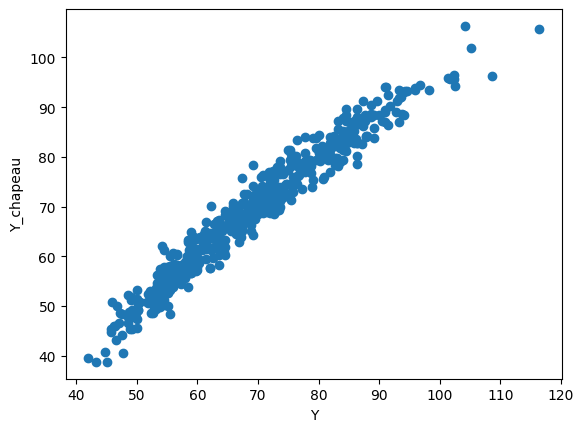

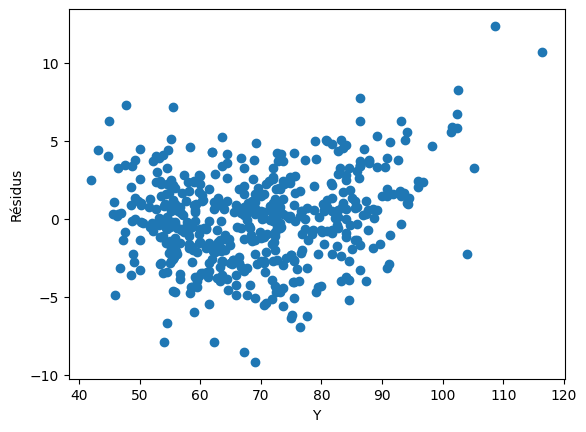

Text(0.5, 0, 'Erreurs')

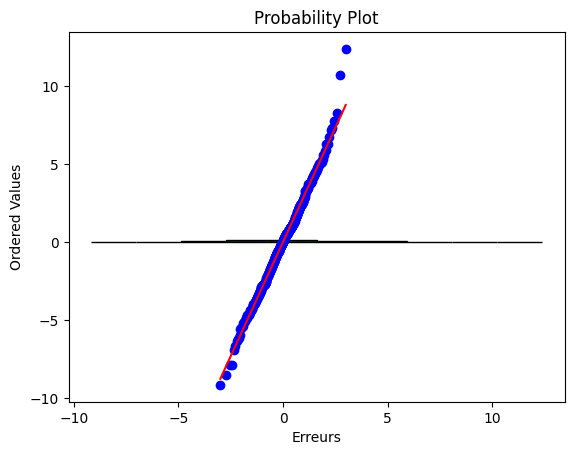

In [9]:

"Vérification modèle"

plt.scatter(Y, Y_chap)
plt.xlabel("Y")
plt.ylabel("Y_chapeau")
plt.show()


Epsilon=Y.values.reshape(-1,1)-Y_chap.values.reshape(-1,1)
plt.figure(1)
plt.plot(Y, Epsilon, 'o')
plt.xlabel("Y")
plt.ylabel("Résidus")
plt.show()
sts.probplot(Epsilon[:,0],dist=sts.norm, plot=plt.figure().add_subplot(111))
ax=plt.hist(Epsilon,density=True, bins = 10, color = 'blue', edgecolor = 'black')
plt.xlabel("Erreurs")


